In [6]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
import json
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

In [44]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import xgboost as xgb

# Process Dataset

### Load Dataset

In [8]:
DATA_PATH = "/kaggle/input/soccer-outcome"

train_path = os.path.join(DATA_PATH, "concatenated_train.json")
test_path = os.path.join(DATA_PATH, "concatenated_test.json")

In [9]:
df_train = pd.read_json(train_path, orient="table")
df_test = pd.read_json(test_path, orient="table")

In [10]:
df_train, df_test = df_train.dropna(), df_test.dropna()
df_train

,EventId,PlayerId,PlayerWeight,PlayerHeight,FavorableFoot,XStart,XEnd,YStart,YEnd,Tags,Goal,MatchId,TeamId,MatchPeriod,EventSec,SubEventId,Id,PlayerSide,inGoal
0,10,25413,73,175,right,88,0,41,0,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",1,2499719,1609,1H,94.595788,100,177959212,1.0,0
1,9,8480,76,185,right,100,12,100,59,"[{'id': 101}, {'id': 1205}, {'id': 1802}]",1,2499719,1631,1H,96.970614,90,177959226,0.0,0
2,3,14853,89,187,left,94,93,0,41,[{'id': 1801}],0,2499719,1631,1H,175.308128,36,177959244,0.0,0
3,10,26150,62,179,left,85,100,52,100,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",0,2499719,1631,1H,179.854785,100,177959247,0.0,0
4,3,7882,90,196,left,0,28,0,44,[],0,2499719,1609,1H,196.066859,34,177959227,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215514,3,3529,74,182,right,42,24,100,74,[{'id': 1801}],0,2565927,682,2H,2773.540076,36,253302621,1.0,0
215515,3,3310,80,174,left,54,37,0,11,[{'id': 1801}],0,2565927,675,2H,2806.801410,36,253302668,0.0,0
215516,3,14723,76,183,right,100,88,100,43,"[{'id': 302}, {'id': 801}, {'id': 1801}]",0,2565927,675,2H,2853.997053,30,253302703,0.0,0
215517,3,3486,82,185,right,0,7,0,16,[],0,2565927,682,2H,2873.020476,34,253302649,1.0,0


## Feature engineering

### Calculate shot distance and shot angle

In [11]:
def get_shot_distance(x,y):
    return np.sqrt(np.power((100-x)*105/100, 2) + np.power((50-y)*68/100, 2))

def get_shot_angle(x, y, tol=1e-6):
    # Translate coordinates to meters using average field dimensions of 105x68
    x_meters = x * 105 / 100
    y_meters = y * 68 / 100

    # Calculate squared distances
    dist1_squared = (105 - x_meters) ** 2 + (34 + 7.32 / 2 - y_meters) ** 2
    dist2_squared = (105 - x_meters) ** 2 + (34 - 7.32 / 2 - y_meters) ** 2
    goal_width_squared = 7.32 ** 2

    # Calculate distances
    dist1 = np.sqrt(dist1_squared)
    dist2 = np.sqrt(dist2_squared)

    # Calculate the angle in radians
    numerator = dist1_squared + dist2_squared - goal_width_squared
    denominator = 2 * dist1 * dist2
    cos_theta = max(-1, min(1, numerator / denominator))
    angle_radians = np.arccos(cos_theta)
    # Translate radians to degrees
    angle_degrees = angle_radians * 180 / np.arccos(-1)

    return angle_degrees


def filter_tags_goals_accurate(tag_list):
    has_101 = any(101 == tag['id'] for tag in tag_list)
    has_range_position_goal = any(1201 <= tag['id'] <= 1209 for tag in tag_list)
    has_shoot_by = any(401 <= tag['id'] <= 403 for tag in tag_list)
#     has_1802 = any(1802 == tag['id'] for tag in tag_list)
    return has_101 and has_range_position_goal and has_shoot_by


def extract_features_position(tag_list):
    features = {
        "ShootBy": None,
        "Opportunity": 0,
        "CounterAttack": 0
    }

    for tag in tag_list:
        set_tags = set()
        if not isinstance(tag['id'], int):  
            continue

        if 401 <= tag['id'] <= 403:
            body_parts = {401: 'left', 402: 'right', 403: 'head/body'}
            features['ShootBy'] = body_parts.get(tag['id'])
        if tag['id'] == 201:
            features['Opportunity'] = 1
        if tag['id'] == 1901:
            features['CounterAttack'] = 1

    return features

In [12]:
# Filter and display the DataFrame
df_train = df_train[df_train['Tags'].apply(filter_tags_goals_accurate)]
df_test = df_test[df_test['Tags'].apply(filter_tags_goals_accurate)]

df_train = df_train[df_train['inGoal'] != 0]
df_test = df_test[df_test['inGoal'] != 0]

# Apply the function and expand the results into new columns
extracted_features_train = df_train['Tags'].apply(extract_features_position).apply(pd.Series)
df_train = pd.concat([df_train, extracted_features_train], axis=1)

extracted_features_test = df_test['Tags'].apply(extract_features_position).apply(pd.Series)
df_test = pd.concat([df_test, extracted_features_test], axis=1)

df_train["ShotDistance"] = df_train.apply(lambda x: get_shot_distance(x["XStart"], x["YStart"]), axis=1)
df_test["ShotDistance"] = df_test.apply(lambda x: get_shot_distance(x["XStart"], x["YStart"]), axis=1)
df_train["ShotAngle"] = df_train.apply(lambda x: get_shot_angle(x["XStart"], x["YStart"]), axis=1)
df_test["ShotAngle"] = df_test.apply(lambda x: get_shot_angle(x["XStart"], x["YStart"]), axis=1)

In [13]:
df_train

,EventId,PlayerId,PlayerWeight,PlayerHeight,FavorableFoot,XStart,XEnd,YStart,YEnd,Tags,...,EventSec,SubEventId,Id,PlayerSide,inGoal,ShootBy,Opportunity,CounterAttack,ShotDistance,ShotAngle
7,10,14763,70,174,right,96,100,52,100,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",...,254.745027,100,177959280,0.0,7,head/body,1,0,4.414703,78.788301
43,10,12829,76,178,right,94,100,54,100,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",...,1710.855093,100,177959759,0.0,3,right,1,0,6.862099,53.847771
71,10,7945,73,185,right,92,0,50,0,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",...,2815.900791,100,177960130,1.0,3,right,1,0,8.400000,47.086890
225,10,8325,70,173,right,89,100,55,100,"[{'id': 101}, {'id': 1901}, {'id': 402}, {'id'...",...,1455.304065,100,178148575,0.0,3,right,1,1,12.040037,32.725142
272,10,8433,82,184,left,91,100,24,100,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",...,2318.473517,100,178122911,0.0,6,left,1,0,20.047067,10.096214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215291,10,225948,65,170,right,79,100,70,100,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",...,1446.421031,100,253623164,0.0,7,right,1,0,25.906804,13.787098
215334,10,26038,72,178,left,88,100,52,100,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",...,1195.769441,100,253221155,0.0,1,left,1,0,12.673184,32.067823
215342,10,93003,83,192,left,95,0,49,0,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",...,1654.888051,100,253221576,1.0,1,right,1,0,5.293855,69.159474
215379,10,265807,72,182,right,88,0,41,0,"[{'id': 101}, {'id': 1901}, {'id': 402}, {'id'...",...,1121.873927,100,253222221,1.0,1,right,1,1,14.007655,26.770923


### Define features and undersampling

In [14]:
input_features = ['XStart', 'YStart', "ShotDistance", "ShotAngle", "PlayerWeight", "PlayerHeight", "FavorableFoot",
                  "ShootBy", "Opportunity", "CounterAttack",
                  "EventId", "PlayerId"]  # Adjust as needed
label_feature = 'inGoal'

In [15]:
df_train[input_features]

,XStart,YStart,ShotDistance,ShotAngle,PlayerWeight,PlayerHeight,FavorableFoot,ShootBy,Opportunity,CounterAttack,EventId,PlayerId
7,96,52,4.414703,78.788301,70,174,right,head/body,1,0,10,14763
43,94,54,6.862099,53.847771,76,178,right,right,1,0,10,12829
71,92,50,8.400000,47.086890,73,185,right,right,1,0,10,7945
225,89,55,12.040037,32.725142,70,173,right,right,1,1,10,8325
272,91,24,20.047067,10.096214,82,184,left,left,1,0,10,8433
...,...,...,...,...,...,...,...,...,...,...,...,...
215291,79,70,25.906804,13.787098,65,170,right,right,1,0,10,225948
215334,88,52,12.673184,32.067823,72,178,left,left,1,0,10,26038
215342,95,49,5.293855,69.159474,83,192,left,right,1,0,10,93003
215379,88,41,14.007655,26.770923,72,182,right,right,1,1,10,265807


In [16]:
# Assuming df is your DataFrame and 'label' is the column with class labels
label_tags = [1, 2, 3, 4, 6, 7, 8, 9]
min_number_train, min_number_test = float('inf'), float('inf')
for tag in label_tags:
    len_tag_train = len(df_train[df_train[label_feature] == tag])
    len_tag_test = len(df_test[df_test[label_feature] == tag])
    min_number_train = len_tag_train if len_tag_train < min_number_train else min_number_train
    min_number_test = len_tag_test if len_tag_test < min_number_test else min_number_test

# Find the number of samples in the minority class
n_samples_train = min_number_train
n_samples_test = min_number_test

# Undersample the majority class
list_data_train, list_data_test = [], []
for tag in label_tags:
    list_data_train.append(df_train[df_train[label_feature] == tag].sample(n_samples_train))
    list_data_test.append(df_test[df_test[label_feature] == tag].sample(n_samples_test))

    
#     class_0_undersampled_train, class_0_undersampled_test = class_0_train.sample(n_samples_train), class_0_test.sample(n_samples_test)
# class_1_undersampled_train, class_1_undersampled_test = class_1_train.sample(n_samples_train), class_1_test.sample(n_samples_test)

# Combine the undersampled data
df_balanced_train = pd.concat(list_data_train)
df_balanced_test = pd.concat(list_data_test)

# Shuffle the DataFrame
df_balanced_train = df_balanced_train.sample(frac=1).reset_index(drop=True)
df_balanced_test= df_balanced_test.sample(frac=1).reset_index(drop=True)

print(df_balanced_train[label_feature].value_counts())
print(df_balanced_test[label_feature].value_counts())

inGoal
4    202
8    202
9    202
2    202
7    202
3    202
1    202
6    202
Name: count, dtype: int64
inGoal
8    11
9    11
4    11
2    11
6    11
1    11
7    11
3    11
Name: count, dtype: int64


In [17]:
df_balanced_test

,EventId,PlayerId,PlayerWeight,PlayerHeight,FavorableFoot,XStart,XEnd,YStart,YEnd,Tags,...,EventSec,SubEventId,Id,PlayerSide,inGoal,ShootBy,Opportunity,CounterAttack,ShotDistance,ShotAngle
0,10,7936,84,191,right,88,0,43,0,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",...,1142.796840,100,89983628,1.0,8,head/body,1,0,13.469135,28.763621
1,3,14817,79,185,right,89,100,51,100,"[{'id': 101}, {'id': 402}, {'id': 1209}, {'id'...",...,58.231732,35,89149150,0.0,9,right,0,0,11.570000,35.061384
2,10,375348,70,177,right,93,100,62,100,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",...,1526.640880,100,260115728,0.0,9,right,1,0,10.982172,26.648679
3,3,14716,90,192,right,89,0,50,0,"[{'id': 101}, {'id': 402}, {'id': 1204}, {'id'...",...,608.796832,35,89883766,1.0,4,right,0,0,11.550000,35.165059
4,10,340646,76,186,right,82,0,75,0,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",...,708.161917,100,261066161,1.0,8,right,1,0,25.420661,12.332162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,3,3685,77,177,left,89,95,52,29,"[{'id': 101}, {'id': 401}, {'id': 1203}, {'id'...",...,1525.087297,35,259958893,0.0,3,left,0,0,11.629794,34.753535
84,3,33235,75,183,right,88,94,50,65,"[{'id': 101}, {'id': 402}, {'id': 1202}, {'id'...",...,1184.372037,35,88180066,0.0,2,right,0,0,12.600000,32.394646
85,10,7870,76,183,right,87,100,51,100,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",...,627.620567,100,88802875,0.0,1,right,1,0,13.666927,29.953296
86,3,3322,83,187,right,90,90,51,26,"[{'id': 101}, {'id': 402}, {'id': 1206}, {'id'...",...,211.536394,35,258700884,1.0,6,right,0,0,10.521996,38.301386


### Transform

In [18]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, Normalizer, PolynomialFeatures

In [19]:
input_features

['XStart',
 'YStart',
 'ShotDistance',
 'ShotAngle',
 'PlayerWeight',
 'PlayerHeight',
 'FavorableFoot',
 'ShootBy',
 'Opportunity',
 'CounterAttack',
 'EventId',
 'PlayerId']

In [20]:
df_balanced_train[input_features]

,XStart,YStart,ShotDistance,ShotAngle,PlayerWeight,PlayerHeight,FavorableFoot,ShootBy,Opportunity,CounterAttack,EventId,PlayerId
0,86,45,15.088075,26.666965,77,182,left,left,1,1,10,70129
1,89,58,12.766993,29.472753,71,184,right,head/body,1,0,10,21174
2,90,50,10.500000,38.434190,61,171,right,right,0,0,3,21123
3,88,84,26.330484,7.725329,60,172,right,right,1,0,10,3474
4,85,49,15.764673,26.119912,73,187,right,right,1,0,10,224680
...,...,...,...,...,...,...,...,...,...,...,...,...
1611,93,56,8.406480,43.209988,90,182,right,right,1,0,10,471
1612,89,58,12.766993,29.472753,83,187,right,head/body,1,0,10,3322
1613,98,53,2.927729,107.422761,78,181,right,head/body,1,0,10,209091
1614,79,34,24.588146,15.270880,72,184,right,right,1,0,3,24269


In [21]:
X_train, X_test = df_balanced_train[input_features], df_balanced_test[input_features]
y_train, y_test = df_balanced_train[label_feature], df_balanced_test[label_feature]

# 2. Encode Categorical Features:

categorical_features = ['FavorableFoot', 'ShootBy', 'Opportunity', 'CounterAttack', 'EventId', 'PlayerId']  # Identify categorical columns
numeric_features = ['XStart', 'YStart', 'ShotDistance', 'ShotAngle', "PlayerWeight","PlayerHeight"]

preprocessor_input = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OrdinalEncoder(), categorical_features)
    ])

label_encoder = LabelEncoder()

X_train = preprocessor_input.fit_transform(X_train)
y_train = label_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()

X_test = preprocessor_input.fit_transform(X_test)
y_test = label_encoder.fit_transform(y_test.values.reshape(-1, 1)).ravel()


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Training Models

### Logistic Regression

In [51]:
model_logistic_regression = LogisticRegression(multi_class='multinomial')
model_logistic_regression.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [52]:
y_pred = model_logistic_regression.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.233     0.636     0.341        11
           1      0.231     0.545     0.324        11
           2      0.250     0.091     0.133        11
           3      0.000     0.000     0.000        11
           4      0.000     0.000     0.000        11
           5      0.429     0.273     0.333        11
           6      0.333     0.273     0.300        11
           7      0.167     0.091     0.118        11

    accuracy                          0.239        88
   macro avg      0.205     0.239     0.194        88
weighted avg      0.205     0.239     0.194        88



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


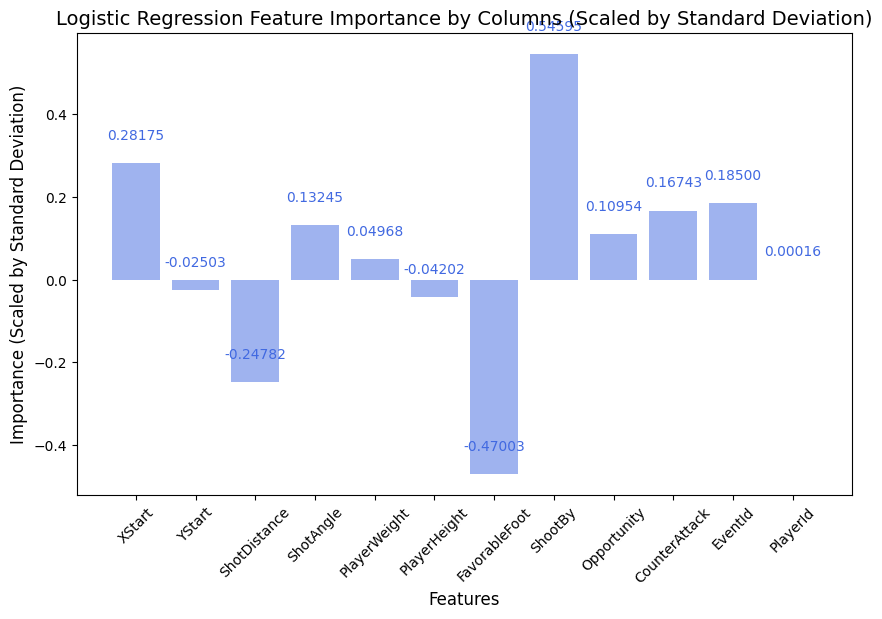

In [53]:
# Get feature importance (coefficients)
feature_importance = model_logistic_regression.coef_[0]

# Calculate scaled feature importance by multiplying with the standard deviation of each feature
scaled_feature_importance = feature_importance

# Create DataFrame for plotting
importance_df = pd.DataFrame({"Feature": input_features, "Importance": scaled_feature_importance})

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df["Feature"], importance_df["Importance"], color="royalblue", alpha=0.5)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Importance (Scaled by Standard Deviation)", fontsize=12)
plt.xticks(rotation=45)
plt.title("Logistic Regression Feature Importance by Columns (Scaled by Standard Deviation)", fontsize=14)

# Add labels to the bars with importance values
for i, v in enumerate(importance_df["Importance"]):
    plt.text(i, v + 0.05, f"{v:.5f}", ha='center', va='bottom', color='royalblue', fontsize=10)

plt.show()

In [54]:
feature_importance

array([ 2.81750453e-01, -2.50340093e-02, -2.47821445e-01,  1.32448202e-01,
        4.96796403e-02, -4.20198832e-02, -4.70026254e-01,  5.45954072e-01,
        1.09535344e-01,  1.67428515e-01,  1.84998872e-01,  1.55016863e-04])

### Random forest

In [26]:
model_random_forest = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=3, verbose=True)
model_random_forest.fit(X_train, y_train)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.7s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    1.7s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:    4.0s finished


RandomForestClassifier(n_estimators=1000, n_jobs=3, random_state=42,
                       verbose=True)

In [27]:
y_pred = model_random_forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=3)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    0.2s


Accuracy: 0.22
Classification Report:
               precision    recall  f1-score   support

           0      0.100     0.091     0.095        11
           1      0.222     0.182     0.200        11
           2      0.143     0.091     0.111        11
           3      0.250     0.091     0.133        11
           4      0.308     0.364     0.333        11
           5      0.152     0.455     0.227        11
           6      0.500     0.182     0.267        11
           7      0.375     0.273     0.316        11

    accuracy                          0.216        88
   macro avg      0.256     0.216     0.210        88
weighted avg      0.256     0.216     0.210        88



[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:    0.3s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:    0.4s finished


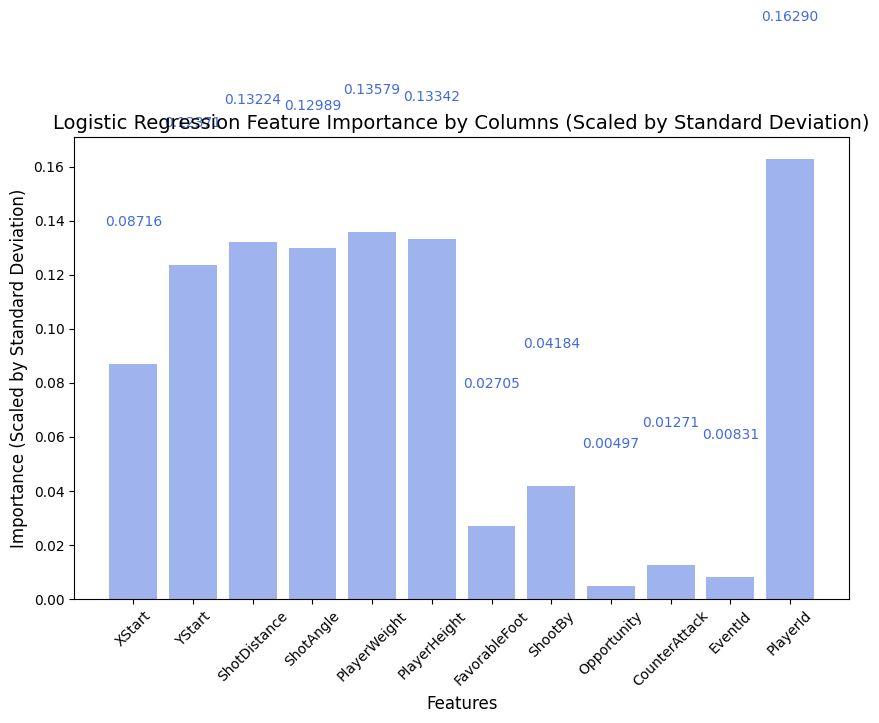

In [58]:
# Get feature importance (coefficients)
feature_importance = model_random_forest.feature_importances_

# Calculate scaled feature importance by multiplying with the standard deviation of each feature
scaled_feature_importance = feature_importance

# Create DataFrame for plotting
importance_df = pd.DataFrame({"Feature": input_features, "Importance": scaled_feature_importance})

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df["Feature"], importance_df["Importance"], color="royalblue", alpha=0.5)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Importance (Scaled by Standard Deviation)", fontsize=12)
plt.xticks(rotation=45)
plt.title("Logistic Regression Feature Importance by Columns (Scaled by Standard Deviation)", fontsize=14)

# Add labels to the bars with importance values
for i, v in enumerate(importance_df["Importance"]):
    plt.text(i, v + 0.05, f"{v:.5f}", ha='center', va='bottom', color='royalblue', fontsize=10)

plt.show()

In [59]:
feature_importance

array([0.08715567, 0.12371126, 0.13224058, 0.12988587, 0.13579408,
       0.1334243 , 0.02705143, 0.04184048, 0.00497162, 0.01270869,
       0.00831152, 0.16290451])

### XGBoost

In [61]:
# 1. Initialize the XGBoost Classifier
xg_boost_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 2. Optional: Hyperparameter Tuning
# (Uncomment and adjust parameters as needed)
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}
grid_search = GridSearchCV(xg_boost_model, params, cv=3)
grid_search.fit(X_train, y_train, verbose = True)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...ne,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200]})

In [62]:
xg_boost_model = grid_search.best_estimator_

# 3. Train the model
xg_boost_model.fit(X_train, y_train, verbose=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [30]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=3)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)


Accuracy: 0.17
Classification Report:
               precision    recall  f1-score   support

           0      0.214     0.273     0.240        11
           1      0.211     0.364     0.267        11
           2      0.200     0.091     0.125        11
           3      0.167     0.091     0.118        11
           4      0.333     0.091     0.143        11
           5      0.095     0.182     0.125        11
           6      0.125     0.091     0.105        11
           7      0.167     0.182     0.174        11

    accuracy                          0.170        88
   macro avg      0.189     0.170     0.162        88
weighted avg      0.189     0.170     0.162        88



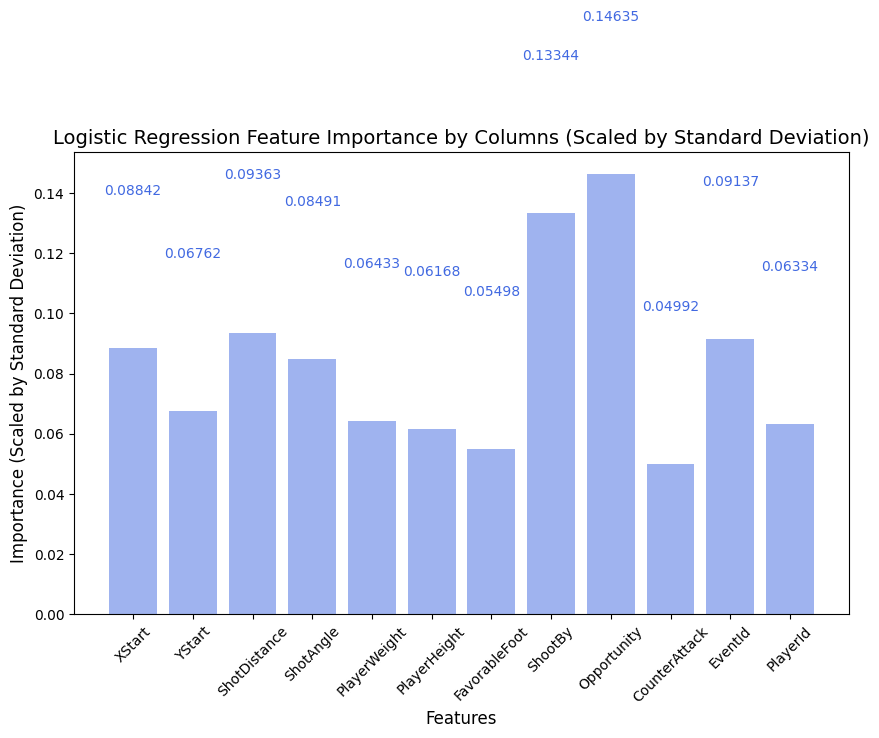

In [63]:
# Get feature importance (coefficients)
feature_importance = xg_boost_model.feature_importances_

# Calculate scaled feature importance by multiplying with the standard deviation of each feature
scaled_feature_importance = feature_importance

# Create DataFrame for plotting
importance_df = pd.DataFrame({"Feature": input_features, "Importance": scaled_feature_importance})

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df["Feature"], importance_df["Importance"], color="royalblue", alpha=0.5)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Importance (Scaled by Standard Deviation)", fontsize=12)
plt.xticks(rotation=45)
plt.title("Logistic Regression Feature Importance by Columns (Scaled by Standard Deviation)", fontsize=14)

# Add labels to the bars with importance values
for i, v in enumerate(importance_df["Importance"]):
    plt.text(i, v + 0.05, f"{v:.5f}", ha='center', va='bottom', color='royalblue', fontsize=10)

plt.show()

In [64]:
feature_importance

array([0.08841827, 0.067623  , 0.09363463, 0.08491472, 0.06432532,
       0.06167965, 0.05497912, 0.13343784, 0.14635357, 0.04992181,
       0.09137082, 0.06334127], dtype=float32)

### LSTM

In [65]:
from keras.utils import to_categorical

In [66]:
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# y_train_lstm = y_train.values.reshape(-1, 1)
# y_test_lstm = y_test.values.reshape(-1, 1)

In [67]:
y_train_lstm = to_categorical(y_train, num_classes=8)
y_test_lstm = to_categorical(y_test, num_classes=8)

In [68]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_train_lstm.shape[2])))
lstm_model.add(Dense(8, activation='softmax'))  # Assuming binary classification

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [69]:
# Train the model
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1180 - loss: 22.2453 - val_accuracy: 0.1477 - val_loss: 2.1156
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1172 - loss: 2.6296 - val_accuracy: 0.1591 - val_loss: 2.0635
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1358 - loss: 2.1651 - val_accuracy: 0.1818 - val_loss: 2.0542
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1505 - loss: 2.1282 - val_accuracy: 0.1932 - val_loss: 2.0689
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1645 - loss: 2.1031 - val_accuracy: 0.1818 - val_loss: 2.0577
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1441 - loss: 2.1080 - val_accuracy: 0.1705 - val_loss: 2.0667
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1722 - loss: 2.0807 - val_accuracy: 0.1818 - val_loss: 2.0465
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1759 - loss: 2.1314 - val_accuracy: 0.1705 - val_loss

In [48]:
from sklearn.metrics import classification_report
import numpy as np

# ... (Your model training code)

# Predict probabilities for each class
y_pred_prob = model.predict(X_test_lstm)

# Get the predicted class labels (the class with the highest probability)
y_pred = np.argmax(y_pred_prob, axis=1)  

# Shift the predicted labels back to the original range (if necessary)
y_pred = y_pred + 1  # This depends on whether your original labels started at 1

# Convert one-hot encoded true labels back to original integer labels
y_true = np.argmax(y_test_lstm, axis=1) + 1  # Again, depending on your original labels

# Create a list of class names to match your labels
target_names = [str(i) for i in range(0, 8)]  # Assuming your original labels were 1-8

# Print the classification report
print(classification_report(y_true, y_pred, target_names=target_names, digits=3)) 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0      0.091     0.091     0.091        11
           1      0.158     0.273     0.200        11
           2      0.125     0.091     0.105        11
           3      0.158     0.273     0.200        11
           4      0.000     0.000     0.000        11
           5      0.211     0.364     0.267        11
           6      0.000     0.000     0.000        11
           7      0.273     0.273     0.273        11

    accuracy                          0.170        88
   macro avg      0.127     0.170     0.142        88
weighted avg      0.127     0.170     0.142        88



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Computing LSTM feature importance...


100%|██████████| 12/12 [00:00<00:00, 12.29it/s]


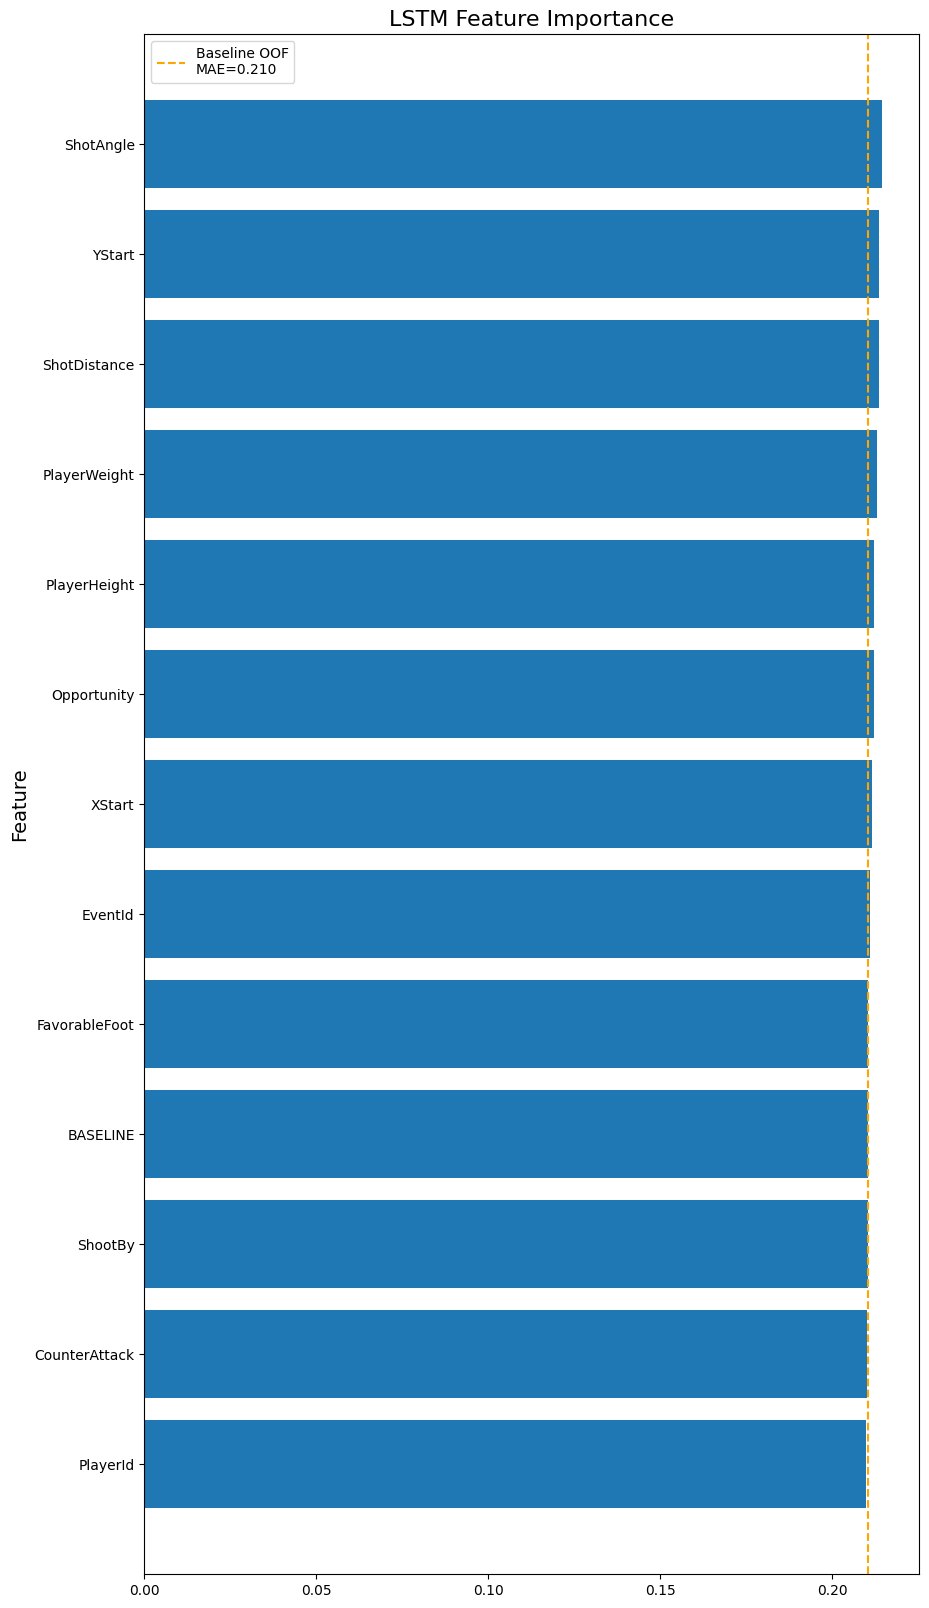

In [77]:
from tqdm import tqdm
COLS = input_features
results = []
print(' Computing LSTM feature importance...')

# COMPUTE BASELINE (NO SHUFFLE)
oof_preds = model.predict(X_test_lstm, verbose=0).squeeze() 
baseline_mae = np.mean(np.abs( oof_preds-y_test_lstm ))
results.append({'feature':'BASELINE','mae':baseline_mae})           

for k in tqdm(range(len(COLS))):

    # SHUFFLE FEATURE K
    save_col = X_test_lstm[:,:,k].copy()
    np.random.shuffle(X_test_lstm[:,:,k])

    # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
    oof_preds = model.predict(X_test_lstm, verbose=0).squeeze() 
    mae = np.mean(np.abs( oof_preds-y_test_lstm ))
    results.append({'feature':COLS[k],'mae':mae})
    X_test_lstm[:,:,k] = save_col

# DISPLAY LSTM FEATURE IMPORTANCE
print()
df = pd.DataFrame(results)
df = df.sort_values('mae')
plt.figure(figsize=(10,20))
plt.barh(np.arange(len(COLS)+1),df.mae)
plt.yticks(np.arange(len(COLS)+1),df.feature.values)
plt.title('LSTM Feature Importance',size=16)
plt.ylim((-1,len(COLS)+1))
plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
         label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
# plt.xlabel(f'Fold {fold+1} OOF MAE with feature permuted',size=14)
plt.ylabel('Feature',size=14)
plt.legend()
plt.show()

In [78]:
results

[{'feature': 'BASELINE', 'mae': 0.21034783188114403},
 {'feature': 'XStart', 'mae': 0.21164197586310057},
 {'feature': 'YStart', 'mae': 0.2135523040504898},
 {'feature': 'ShotDistance', 'mae': 0.21352316906716176},
 {'feature': 'ShotAngle', 'mae': 0.21457242502539617},
 {'feature': 'PlayerWeight', 'mae': 0.21311633471399008},
 {'feature': 'PlayerHeight', 'mae': 0.21209724055309984},
 {'feature': 'FavorableFoot', 'mae': 0.210460625158752},
 {'feature': 'ShootBy', 'mae': 0.21028080986530479},
 {'feature': 'Opportunity', 'mae': 0.21198154162776267},
 {'feature': 'CounterAttack', 'mae': 0.21008974229853097},
 {'feature': 'EventId', 'mae': 0.21086765871616883},
 {'feature': 'PlayerId', 'mae': 0.20975170083716363}]